In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install langdetect
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 


import re
import nltk
# import langdetect 
import gensim
import gensim.downloader as gensim_api
import spacy


from sklearn.metrics import accuracy_score, auc, precision_score,\
recall_score, f1_score
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from textblob import TextBlob
from sklearn.model_selection import train_test_split

from textblob import TextBlob

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer


In [93]:
sns.set_style('darkgrid')

In [94]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [95]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)


In [96]:
link1 = '/content/drive/MyDrive/Corona_NLP_test.csv'
data_test = pd.read_csv(link1)
link2 = '/content/drive/MyDrive/Corona_NLP_train.csv'
data_train = pd.read_csv(link2, encoding = 'latin1')

In [97]:
data_train.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive


In [98]:
# perfrom NER on this 

data_train['Location'].sample(10)

4428              Melbourne
18908       Tulsa, Oklahoma
37748                   NaN
26826      New Delhi, India
20552               Brixham
21769    Akwa Ibom, Nigeria
38249                   NaN
12364            Texas, USA
2                 Vagabonds
3838                    NaN
Name: Location, dtype: object

In [99]:
# More features than just the text

data_train.shape

(41157, 6)

In [100]:
# Some null values
# Only for location 

data_train.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [101]:
data_train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [102]:
# Low importance feature
# Too many unique values

data_train['ScreenName'].nunique()

41157

In [103]:
# Low importance feature
# Too many unique values

data_train['UserName'].nunique()

41157

In [104]:
data_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## **Feature Engineering**

In [105]:
# Drop features UserName, ScreenName
# They may have some information 
# Just not explored yet 

df = data_train.copy()
df.drop(['UserName', 'ScreenName'], axis = 1, inplace = True)
df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [106]:
df.dtypes

Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [107]:
# Change the values of the Target Variable to numeric

df = df.replace({'Sentiment': {'Extremely Negative': -2 , 'Negative' :-1 ,
                              'Neutral' : 0, 'Positive' : 1, 'Extremely Positive' : 2 }

})

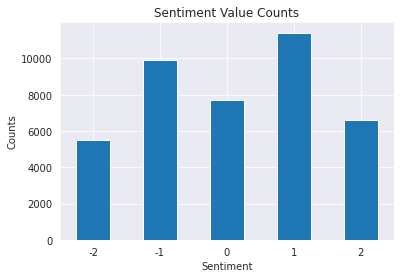

In [108]:
df['Sentiment'].value_counts().sort_index().plot.bar(rot = 0,
                                                     title = 'Sentiment Value Counts',
                                                     ylabel = 'Counts',
                                                     xlabel = 'Sentiment')

In [109]:
# Changing TweetAt to datetime type

df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df.dtypes

Location                 object
TweetAt          datetime64[ns]
OriginalTweet            object
Sentiment                 int64
dtype: object

In [110]:
# Verify if TweetAt has changed to the right format

df.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",-2


In [111]:
df['TweetAt'].dt.dayofweek.value_counts()

2    7440
1    6892
3    6234
4    6067
5    5916
0    5364
6    3244
Name: TweetAt, dtype: int64

In [112]:
# Insert a month column - Feature creation from TweetAt
# Feature engineering

df.insert(2, 'Month', df['TweetAt'].dt.month, True)

df.head()

,Location,TweetAt,Month,OriginalTweet,Sentiment
0,London,2020-03-16,3,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,3,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,3,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,3,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,3,"Me, ready to go at supermarket during the #COV...",-2


In [113]:
# Insert more date-time based features

df.insert(3, 'Quarter', df['TweetAt'].dt.quarter, True)
df.insert(4, 'Year', df['TweetAt'].dt.year, True)
df.insert(5, 'DayOfWeek', df['TweetAt'].dt.dayofweek, True)

df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2


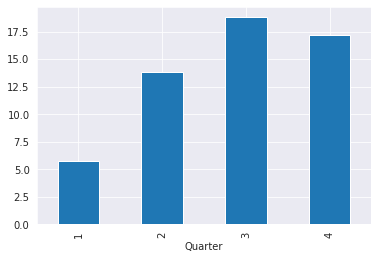

In [114]:
# Sentiment analysis by quarter

round((df.groupby('Quarter')['Sentiment'].mean()*100),2).plot.bar()

In [115]:
# If you find median of Sentiment then it is 0
# So mean is a better measure of Central Tendency
# Frankly there are no outliers so mean is fair to use

df.loc[df['Quarter'] == 1]['Sentiment'].mean()

0.05757716989925788

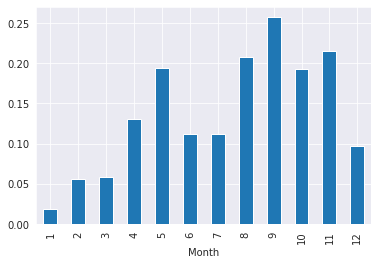

In [116]:
# Sentiment analysis by month
# Do LDA for month with highest 
# Do LDA for month with lowest

df.groupby('Month')['Sentiment'].mean().plot.bar()

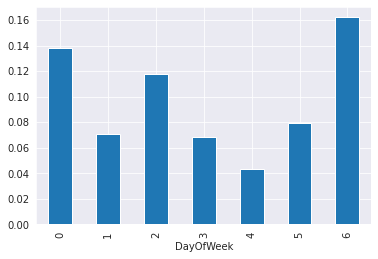

In [117]:
# Day of the Week analysis

df.groupby('DayOfWeek')['Sentiment'].mean().plot.bar()

In [118]:
from nltk.tokenize import TweetTokenizer

In [119]:
df['OriginalTweet_Len'] = df['OriginalTweet'].apply(len)
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310


In [120]:
# To get the WordNetLemmatizer

import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [121]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=True, flg_lemm=False, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'https?:\S*', '', str(text).lower().strip())
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
           
    
    ## Tokenize (convert from string to list)
    tk = TweetTokenizer()
    lst_text = tk.tokenize(text)

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [122]:
sw = stopwords.words('english')
sw

df["txt"] = df["OriginalTweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))

In [123]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...


In [124]:
df['txt_len'] = df['txt'].apply(len)


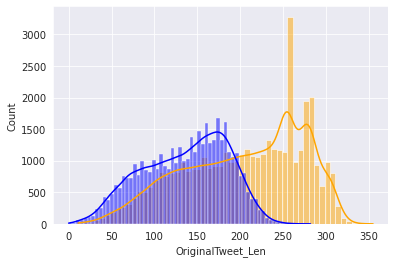

In [125]:
# Compare the distributions 
# Of text lengths
# Original vs cleaned text

sns.histplot(data = df , x = 'OriginalTweet_Len', color = 'orange', kde = 'True')
sns.histplot(data = df , x = 'txt_len', color = 'blue', kde = 'True')

In [126]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv,28
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,100
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,182
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,192


In [127]:
# Various features can be created

'''
df['word_count'] = df["text"].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["text"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['char_count'] / df['word_count']
df['avg_sentence_lenght'] = df['word_count'] / df['sentence_count']
df.head()

'''

'\ndf[\'word_count\'] = df["text"].apply(lambda x: len(str(x).split(" ")))\ndf[\'char_count\'] = df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))\ndf[\'sentence_count\'] = df["text"].apply(lambda x: len(str(x).split(".")))\ndf[\'avg_word_length\'] = df[\'char_count\'] / df[\'word_count\']\ndf[\'avg_sentence_lenght\'] = df[\'word_count\'] / df[\'sentence_count\']\ndf.head()\n\n'

In [128]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv,28
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,100
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,182
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,192


In [129]:
# Another way for text pre processing 

'''
import string
from nltk.corpus import stopwords

sw = stopwords.words('english')
print(sw)
print (string.punctuation)

def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

 # df['tokenized_tweet'] = df['OriginalTweet'].apply(text_process)

'''

"\nimport string\nfrom nltk.corpus import stopwords\n\nsw = stopwords.words('english')\nprint(sw)\nprint (string.punctuation)\n\ndef text_process(msg):\n    nopunc =[char for char in msg if char not in string.punctuation]\n    nopunc=''.join(nopunc)\n    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])\n\n # df['tokenized_tweet'] = df['OriginalTweet'].apply(text_process)\n\n"

## **NER**

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
'''
To get the Named Entity in the 
'''

def show_ents(data):
  doc = nlp(data)
  if doc.ents:
    for ent in doc.ents:
      # print(ent.text+' - ' +str(ent.start_char) +' - '+ str(ent.end_char) +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_)))
      # print(ent.text+' - ' + ent.label_ + ' - '+str(spacy.explain(ent.label_)))
        return ent.label_
  else:
    # print('No named entities found.')
    return None

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv,28
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,100
3,NaN,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,182
4,NaN,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,192


In [ ]:
# Filling null values of 'Location' with placeholder null 

df['Location'] = df['Location'].fillna('none')
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv,28
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,100
3,none,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,182
4,none,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,192


In [ ]:
df['location_ner'] = df['Location'].apply(show_ents)

In [ ]:
df.head()

,Location,TweetAt,Month,Quarter,Year,DayOfWeek,OriginalTweet,Sentiment,OriginalTweet_Len,txt,txt_len,location_ner
0,London,2020-03-16,3,1,2020,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,111,menyrbie phil_gahan chrisitv,28,GPE
1,UK,2020-03-16,3,1,2020,0,advice Talk to your neighbours family to excha...,1,237,advice talk neighbour family exchange phone nu...,185,GPE
2,Vagabonds,2020-03-16,3,1,2020,0,Coronavirus Australia: Woolworths to give elde...,1,131,coronavirus australia woolworth give elderly d...,100,None
3,none,2020-03-16,3,1,2020,0,My food stock is not the only one which is emp...,1,306,food stock one empty please dont panic enough ...,182,None
4,none,2020-03-16,3,1,2020,0,"Me, ready to go at supermarket during the #COV...",-2,310,ready go supermarket covid 19 outbreak im para...,192,None


In [ ]:
# See the value_counts

from collections import Counter
Counter(df['location_ner'])

Counter({'GPE': 21209,
         None: 13536,
         'CARDINAL': 272,
         'ORG': 3475,
         'PERSON': 1430,
         'LOC': 884,
         'NORP': 169,
         'ORDINAL': 16,
         'FAC': 30,
         'MONEY': 23,
         'DATE': 60,
         'WORK_OF_ART': 10,
         'PRODUCT': 15,
         'TIME': 3,
         'QUANTITY': 9,
         'EVENT': 10,
         'LANGUAGE': 2,
         'PERCENT': 2,
         'LAW': 2})

In [ ]:
# Most are showing locations 
# Need to see which ones can show countries

df['location_ner'].value_counts()

GPE            21209
ORG             3475
PERSON          1430
LOC              884
CARDINAL         272
NORP             169
DATE              60
FAC               30
MONEY             23
ORDINAL           16
PRODUCT           15
WORK_OF_ART       10
EVENT             10
QUANTITY           9
TIME               3
LANGUAGE           2
PERCENT            2
LAW                2
Name: location_ner, dtype: int64

In [ ]:
# Mostly are all are misclassified
# Those classified as 'ORG' seem to be genuine locations

df.loc[df['location_ner'] == 'ORG']

In [ ]:
# Some garbage
# But a lot of useful Locations have not had apt NER identification done on them 

df.loc[(df['location_ner'].isnull() == True) & (df['Location'] != 'none')]

In [ ]:
df['location_ner'].isnotnull().sum()

AttributeError: ignored

## **LDA**

## **Data preparation + Model - LSTM**

In [167]:
# Just like the train data

data_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [168]:
df_test = data_test.copy()
df_test = data_test[['OriginalTweet', 'Sentiment']]
df_test.columns = ['txt', 'sentiment']

df_test.head()

,txt,sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [169]:
df_train = df[['txt', 'Sentiment']]
df_train.columns = ['txt', 'sentiment']
df_train.head()

,txt,sentiment
0,menyrbie phil_gahan chrisitv,0
1,advice talk neighbour family exchange phone nu...,1
2,coronavirus australia woolworth give elderly d...,1
3,food stock one empty please dont panic enough ...,1
4,ready go supermarket covid 19 outbreak im para...,-2


In [170]:
print(df_test.shape)
df_train.shape

(3798, 2)


(41157, 2)

In [171]:
# Change the values of the Target Variable to numeric
# Apply same preprocessing to test data
# As done with train data


df_train = df_train.replace({'sentiment': {-2: 'Extremely Negative', -1: 'Negative',
#                             0: 'Neutral', 1: 'Positive', 2: 'Extremely Positive' }
#
# })

df_train = df_train.replace({'sentiment': {'Extremely Negative' : 0, 'Negative' : 1,
                              'Neutral' : 2, 'Positive' : 3, 'Extremely Positive' : 4}

})


df_test = df_test.replace({'sentiment': {'Extremely Negative' : 0, 'Negative' : 1,
                              'Neutral' : 2, 'Positive' : 3, 'Extremely Positive' : 4}

})
sw = stopwords.words('english')
sw

df_test["txt"] = df_test["txt"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))
df_test.head()

,txt,sentiment
0,trending new yorkers encounter empty supermark...,-2
1,couldnt find hand sanitizer fred meyer turned ...,1
2,find protect loved one coronavirus,2
3,panic buying hit newyork city anxious shopper ...,-1
4,toiletpaper dunnypaper coronavirus coronavirus...,0


In [ ]:
# May not be necessary



label_encoder = preprocessing.LabelEncoder()
df_train['sentiment'] = label_encoder.fit_transform(df_train['sentiment'])
df_test['sentiment'] = label_encoder.fit_transform(df_test['sentiment'])


In [173]:
df_train.head()

,txt,sentiment
0,menyrbie phil_gahan chrisitv,2
1,advice talk neighbour family exchange phone nu...,3
2,coronavirus australia woolworth give elderly d...,3
3,food stock one empty please dont panic enough ...,3
4,ready go supermarket covid 19 outbreak im para...,0


In [174]:
X_train, y_train, X_test, y_test = df_train['txt'], df_train['sentiment'], df_test['txt'], df_test['sentiment']

In [ ]:
# pd.get_dummies(df_train['sentiment']).values

In [175]:
EMBEDDING_DIMENSION = 128
VOCABULARY_SIZE = 5000
MAX_LENGTH = 200
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'


In [176]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Dropout, Activation
from sklearn import preprocessing
from keras.datasets import imdb


from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D


In [ ]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
word_index

In [178]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen = MAX_LENGTH,
                               padding = PADDING_TYPE, truncating = TRUNCATE_TYPE)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen = MAX_LENGTH,
                               padding = PADDING_TYPE, truncating = TRUNCATE_TYPE)



In [163]:
# Is this necessary

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))


In [183]:
y_train.unique()

array([2, 3, 0, 1, 4])

In [ ]:
# A possible architecture

'''
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
'''

In [184]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     EMBEDDING_DIMENSION))
model.add(LSTM(32))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [158]:
y_train.shape

(41157,)

In [186]:
num_epochs = 3
history = model.fit(X_train_padded, y_train,
                    batch_size = 128, epochs=num_epochs,
                    validation_data=(X_test_padded, y_test), verbose=2)


Epoch 1/3
322/322 - 90s - loss: 1.5760 - accuracy: 0.2775 - val_loss: 1.5820 - val_accuracy: 0.2493 - 90s/epoch - 280ms/step
Epoch 2/3
322/322 - 84s - loss: 1.5755 - accuracy: 0.2775 - val_loss: 1.5888 - val_accuracy: 0.2493 - 84s/epoch - 262ms/step
Epoch 3/3
322/322 - 99s - loss: 1.5755 - accuracy: 0.2775 - val_loss: 1.5868 - val_accuracy: 0.2493 - 99s/epoch - 309ms/step


In [ ]:

embed_dim = 512
lstm_out = 200
batch_size = 128

model = Sequential()
model.add(Embedding(5000, embed_dim))
model.add(LSTM(lstm_out , dropout = 0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 512)         2560000   
                                                                 
 lstm_3 (LSTM)               (None, 200)               570400    
                                                                 
 dense_3 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 3,131,405
Trainable params: 3,131,405
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
score,acc = model.evaluate(X_valid, Y_valid, batch_size = 128, verbose = 2)

65/65 - 1s - loss: 1.4877 - accuracy: 0.6624 - 795ms/epoch - 12ms/step


In [ ]:
# only seem to be getting a 66% accuracy
# which is poor for a sentiment classification problem

print(score)
print(acc)



1.4877482652664185
0.6624149680137634


## **Data preparation - For logistic regression**

In [ ]:
df_test = data_test.copy()

In [ ]:
df_test["txt"] = df_test["OriginalTweet"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords= sw))
df_test.head()

In [ ]:
X_test = df_test.copy()

X_test.drop([col for col in X_test.columns if col not in ['txt', 'Sentiment']], axis = 1, inplace = True)

y_test = X_test.pop('Sentiment')

y_test = y_test.replace({'Extremely Negative':-2 ,'Negative': -1, 'Neutral':0,
                         'Positive':1, 'Extremely Positive' : 2
                         })


In [ ]:
X_train = df.copy()
X_train.drop([col for col in X_train.columns if col not in ['txt', 'Sentiment']], axis = 1, inplace = True)

y_train = X_train.pop('Sentiment')
X_train.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 10)


In [ ]:
train_vectorized = vectorizer.fit_transform(X_train['txt'])
test_vectorized = vectorizer.transform(X_test['txt'])

In [ ]:
train_vectorized

In [ ]:
train_array= train_vectorized.toarray()
test_array = test_vectorized.toarray()

In [ ]:
print(train_array.shape)
print(test_array.shape)

## **Model-Logistic**

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, max_iter=10000)
clf.fit(train_array, y_train)

LogisticRegression(max_iter=10000)

In [ ]:
train_class_preds = clf.predict(train_array)
test_class_preds = clf.predict(test_array)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


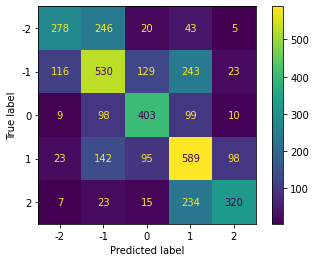

In [ ]:
plot_confusion_matrix(clf, test_array, y_test)

In [ ]:
f1_score(y_test, test_class_preds, average = None)

array([0.54243902, 0.50961538, 0.62919594, 0.54663573, 0.60663507])

In [ ]:
print(classification_report(y_test, test_class_preds), "\n")


              precision    recall  f1-score   support

          -2       0.64      0.47      0.54       592
          -1       0.51      0.51      0.51      1041
           0       0.61      0.65      0.63       619
           1       0.49      0.62      0.55       947
           2       0.70      0.53      0.61       599

    accuracy                           0.56      3798
   macro avg       0.59      0.56      0.57      3798
weighted avg       0.57      0.56      0.56      3798
 



## **Model - LSTM**

## **OOB sentiment classification**